[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module2_Files/Assignment3.ipynb)

# Neural Network Classification Project

For this project, I built a full end-to-end neural network classification pipeline using the CalEnviroScreen 4.0 dataset. The goal was to predict whether a community falls into a high-poverty category based on environmental, health, and socioeconomic indicators.

##Data Understanding and Preparation

I began by reviewing the official CalEnviroScreen 4.0 data dictionary to understand the meaning, scale, and quality of each variable. I downloaded the dataset programmatically using gdown and loaded the Excel file into pandas. I inspected the first few rows using df.head() and examined data types and missing values using df.info() to assess overall data quality.

To simplify the dataset, I selected only the variables needed for modeling. The input features (X) included population, pollution exposure percentiles (from Ozone through Solid Waste Percentile), and health and vulnerability indicators (from Asthma through Linguistic Isolation Percentile). The target variable (y) was Poverty. I carefully examined missing values and data distributions for each column and used a combination of row removal and imputation where appropriate, documenting all decisions with comments and text explanations.

##Target Engineering

To convert the problem into a classification task, I recoded the poverty variable into a binary target. Observations with poverty values greater than the mean poverty level were labeled as 1 (high poverty), and those below or equal to the mean were labeled as 0. This allowed me to frame the task as a binary classification problem.

##Exploratory Analysis

I created two exploratory plots/tables to better understand the data and justify modeling choices. These visualizations helped highlight relationships between environmental exposures, health indicators, and poverty levels, and provided intuition for why these variables are meaningful predictors.

##Train-Test Split and Scaling

I split the data into training and testing sets using a 90/10 split, with the random seed set equal to my 7-digit student ID to ensure reproducibility. I applied StandardScaler() to the training features and used the same fitted scaler on the test set to prevent data leakage. The target variable was not scaled.

##Neural Network Model

I built a feedforward neural network using the Keras Sequential API. The architecture included multiple dense layers with ReLU activation functions and dropout regularization between layers to reduce overfitting. I compiled the model using an appropriate optimizer and loss function for binary classification.

To control training, I implemented early stopping with a patience of at least 10 epochs and enabled restoration of the best model weights once convergence was reached. The model was configured to run for up to 100,000 epochs, but training stopped early based on validation performance. I used the test set as validation data during training.

##Model Evaluation

I evaluated model performance using learning curves, error metrics, and confusion matrices for both the training and test partitions. These evaluations helped assess convergence behavior, generalization performance, and classification accuracy. I included written interpretation discussing whether the model learned smoothly and whether signs of overfitting or underfitting were present.

## Baseline Comparison

Finally, I calculated baseline predictions using a mean-only model for both the training and test sets. I compared the neural network’s performance against this baseline to determine whether the model added predictive value. The neural network outperformed the baseline, indicating that the learned relationships were meaningful and the model was useful.

# Read Data and Import Modules

In [ ]:
!pip install keras

In [ ]:
# import modules
# for general data analysis/plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# for data prep
from sklearn.model_selection import train_test_split

# neural net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# Read the data

Read the data dictionary and description from here:
https://oehha.ca.gov/media/downloads/calenviroscreen/document/calenviroscreen40resultsdatadictionaryf2021.zip
Download the data using gdown, read the Excel file using pandas, print the first 10 rows using df.head() and use df.info() to examine the data types and missing values.

In [ ]:
# Link to the data file on Github
url = "https://github.com/drdave-teaching/OPIM5509Files/raw/main/OPIM5509_Module2_Files/CalEnviroScreen.xlsx"

# retrieve the data and build a dataframe
df_CalEnviroScreen = pd.read_excel(url)

df_CalEnviroScreen.shape

(8035, 57)

# EDA

Simplify the raw dataframe so that you only keep the columns you need. The X variable will be the following columns: Population, Ozone through Solid Waste Pctl, and Asthma through Linguistic Isolation Pctl. The y variable will be Poverty. Examine the quality of each column and use your judgement about dropping rows or imputing missing values. Add text cells and lots of comments so we can understand your logic/justification!

In [ ]:
# Printing the first 10 rows
df_CalEnviroScreen.head(10)

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),...,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),...,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),...,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),...,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),...,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752
5,6037204920,2598,Los Angeles,90023,Los Angeles,-118.197497,34.017500,80.726872,99.936940,95-100% (highest scores),...,89.148114,66.4,90.232558,11.6,67.419723,22.0,67.034780,82.361214,8.541407,94.892168
6,6077000300,2396,San Joaquin,95203,Stockton,-121.302072,37.952421,80.178935,99.924328,95-100% (highest scores),...,92.401013,76.2,97.033312,14.4,82.002792,24.3,74.727088,91.940147,9.534806,99.646866
7,6019001000,4106,Fresno,93706,Fresno,-119.804314,36.697751,80.134819,99.911716,95-100% (highest scores),...,76.576456,74.5,95.901948,20.0,95.494352,31.8,90.720995,93.793697,9.727032,99.911716
8,6037206050,2146,Los Angeles,90023,Los Angeles,-118.224453,34.029904,79.025293,99.899105,95-100% (highest scores),...,97.120384,75.7,96.643620,28.5,99.505013,31.7,90.555979,80.249569,8.322415,92.962543
9,6019000400,6343,Fresno,93721,Fresno,-119.776209,36.727656,78.529850,99.886493,95-100% (highest scores),...,71.350487,83.4,99.082338,23.5,98.273893,23.2,71.337903,83.195409,8.627918,95.711943


In [ ]:
# printing the last 10 rows
df_CalEnviroScreen.tail(10)

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
8025,6037920011,286,Los Angeles,91390,Santa Clarita,-118.420095,34.545587,NaN,NaN,NaN,...,NaN,31.9,47.856694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8026,6085504417,323,Santa Clara,95035,Milpitas,-121.852539,37.432128,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8027,6053014104,1611,Monterey,93955,Seaside,-121.798753,36.651862,NaN,NaN,NaN,...,NaN,NaN,NaN,34.2,99.898464,NaN,NaN,NaN,NaN,NaN
8028,6079012800,1107,San Luis Obispo,93422,Atascadero,-120.634878,35.467259,NaN,NaN,NaN,...,NaN,48.2,71.162791,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8029,6017031900,133,El Dorado,95720,Kyburz,-120.265770,38.729519,NaN,NaN,NaN,...,NaN,24.7,35.763671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8030,6009000504,942,Calaveras,95223,Arnold,-120.211151,38.405130,NaN,NaN,NaN,...,NaN,24.7,35.763671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8031,6065940100,166,Riverside,92239,Desert Center,-114.475335,34.000183,NaN,NaN,NaN,...,NaN,21.0,28.812068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8032,6053011502,1710,Monterey,93923,Carmel,-121.735102,36.301079,NaN,NaN,NaN,...,10.758566,29.0,43.067253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8033,6083980100,11,Santa Barbara,57,Channel Islands,-120.048221,33.948186,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8034,6111980000,56,Ventura,61,Channel Is Air Guard Station,-119.503588,33.255655,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# column names
df_CalEnviroScreen.columns

Index(['Census Tract', 'Total Population', 'California County', 'ZIP',
       'Nearby City \n(to help approximate location only)', 'Longitude',
       'Latitude', 'CES 3.0 Score', ' CES 3.0 Percentile',
       'CES 3.0 \nPercentile Range', 'SB 535 Disadvantaged Community', 'Ozone',
       'Ozone Pctl', 'PM2.5', 'PM2.5 Pctl', 'Diesel PM', 'Diesel PM Pctl',
       'Drinking Water', 'Drinking Water Pctl', 'Pesticides',
       'Pesticides Pctl', 'Tox. Release', 'Tox. Release Pctl', 'Traffic',
       'Traffic Pctl', 'Cleanup Sites', 'Cleanup Sites Pctl',
       'Groundwater Threats', 'Groundwater Threats Pctl', 'Haz. Waste',
       'Haz. Waste Pctl', 'Imp. Water Bodies', 'Imp. Water Bodies Pctl',
       'Solid Waste', 'Solid Waste Pctl', 'Pollution Burden',
       'Pollution Burden Score', 'Pollution Burden Pctl', 'Asthma',
       'Asthma Pctl', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Cardiovascular Disease', 'Cardiovascular Disease Pctl', 'Education',
       'Education Pctl', 

In [ ]:
# describe() gives summary statistics
df_CalEnviroScreen.describe()

,Census Tract,Total Population,ZIP,Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,Ozone,Ozone Pctl,PM2.5,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
count,8.035000e+03,8035.000000,8035.000000,8035.000000,8035.000000,7929.000000,7929.000000,8035.000000,8035.000000,8016.000000,...,7793.000000,7956.000000,7956.000000,7880.000000,7880.000000,7878.000000,7878.000000,7929.000000,7929.000000,7929.000000
mean,6.054896e+09,4636.459988,92836.574611,-119.409318,35.495893,27.925260,50.006306,0.047454,53.298961,10.377904,...,48.357838,36.386790,50.071387,10.214327,50.318100,19.327913,50.178719,49.892343,5.174168,50.006306
std,2.652280e+07,1972.587602,3445.177594,1.976336,2.086016,16.171111,28.869334,0.010283,28.602241,2.598074,...,29.764977,20.316885,28.856303,5.136715,28.802973,8.734286,28.838655,20.623803,2.138826,28.869334
min,6.001400e+09,0.000000,32.000000,-124.297889,32.547376,0.981202,0.012612,0.026421,0.236465,1.651081,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.025387,2.532893,0.262678,0.012612
25%,6.037265e+09,3358.000000,91602.000000,-121.518410,33.924145,14.958110,25.009459,0.040127,25.874300,8.697944,...,22.516998,19.200000,25.103708,6.600000,25.460084,12.900000,25.514090,33.762688,3.501416,25.009459
50%,6.059053e+09,4413.000000,92691.000000,-118.429194,34.206624,25.060225,50.006306,0.046178,53.018046,10.370000,...,48.340221,33.500000,50.106851,9.300000,50.272877,18.000000,50.330033,49.957244,5.180899,50.006306
75%,6.073016e+09,5656.500000,94558.000000,-117.924814,37.634021,39.350097,75.003153,0.055122,77.871811,12.050000,...,74.230103,51.500000,75.021999,12.900000,75.517198,24.400000,75.006347,66.448338,6.891136,75.003153
max,6.115041e+09,37452.000000,96161.000000,-114.306484,41.946648,94.090246,100.000000,0.067829,100.000000,19.600000,...,100.000000,96.200000,100.000000,100.000000,100.000000,67.200000,100.000000,96.425818,10.000000,100.000000


In [ ]:
# examining the data type and missing values
# data info
df_CalEnviroScreen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 57 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Census Tract                                      8035 non-null   int64  
 1   Total Population                                  8035 non-null   int64  
 2   California County                                 8035 non-null   object 
 3   ZIP                                               8035 non-null   int64  
 4   Nearby City 
(to help approximate location only)  8035 non-null   object 
 5   Longitude                                         8035 non-null   float64
 6   Latitude                                          8035 non-null   float64
 7   CES 3.0 Score                                     7929 non-null   float64
 8    CES 3.0 Percentile                               7929 non-null   float64
 9   CES 3.0 
Percentile

In [ ]:
# describe() gives summary statistics
df_CalEnviroScreen.isnull().sum().sum()

np.int64(2724)

In [ ]:
# missing values by column
df_CalEnviroScreen.isnull().sum()

,0
Census Tract,0
Total Population,0
California County,0
ZIP,0
Nearby City \n(to help approximate location only),0
Longitude,0
Latitude,0
CES 3.0 Score,106
CES 3.0 Percentile,106
CES 3.0 \nPercentile Range,106


In [ ]:
# drop any rows with missing values
df_CalEnviroScreen.dropna(axis = 0, inplace = True)
df_CalEnviroScreen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 0 to 7928
Data columns (total 57 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Census Tract                                      7557 non-null   int64  
 1   Total Population                                  7557 non-null   int64  
 2   California County                                 7557 non-null   object 
 3   ZIP                                               7557 non-null   int64  
 4   Nearby City 
(to help approximate location only)  7557 non-null   object 
 5   Longitude                                         7557 non-null   float64
 6   Latitude                                          7557 non-null   float64
 7   CES 3.0 Score                                     7557 non-null   float64
 8    CES 3.0 Percentile                               7557 non-null   float64
 9   CES 3.0 
Percentile Rang

In [ ]:
# missing values by column
df_CalEnviroScreen.isnull().sum()

,0
Census Tract,0
Total Population,0
California County,0
ZIP,0
Nearby City \n(to help approximate location only),0
Longitude,0
Latitude,0
CES 3.0 Score,0
CES 3.0 Percentile,0
CES 3.0 \nPercentile Range,0


In [ ]:
# Selecting Features (X) and Target (y)
# Step 1: Make a copy of the raw df
df_clean = df_CalEnviroScreen.copy()

# Step 2: Select feature columns
# Find the correct start/end indices by column names
cols = df_clean.columns

# Get columns for ranges
ozone_to_solid = cols[cols.get_loc("Ozone"): cols.get_loc("Solid Waste Pctl")+1]
asthma_to_ling = cols[cols.get_loc("Asthma"): cols.get_loc("Linguistic Isolation Pctl")+1]

# Combine all feature columns
feature_cols = ["Total Population"] + list(ozone_to_solid) + list(asthma_to_ling)

X = df_clean[feature_cols]
y = df_clean["Poverty"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (7557, 35)
y shape: (7557,)


In [ ]:
X.head()

,Total Population,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,...,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl
0,3174,0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,2.749604,...,131.64,97.668620,7.44,93.835704,14.13,96.309687,53.3,95.760787,16.2,77.509665
1,6133,0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,1.365360,...,60.66,69.779329,7.04,90.849673,12.94,92.656776,53.3,95.760787,33.4,96.253833
2,3167,0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,3.025629,...,142.12,98.329385,10.16,99.782135,14.96,97.668620,42.3,89.061317,16.7,78.389548
3,6692,0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,12.926266,...,142.17,98.341853,6.23,80.648469,14.72,97.169929,40.8,87.522079,15.3,75.136648
4,2206,0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,3518.413336,...,90.48,89.539958,4.50,38.920928,12.82,92.357561,45.1,91.130457,14.7,73.723504


# Target Variable Transformation: Poverty → Binary Classification

Recode the target variable to a 1 if greater than the mean value of poverty, otherwise make it a 0. Use this recoded variable as the target variable! Now it is a classification problem.

In [ ]:
# Step 1: Calculate mean of Poverty
poverty_mean = df_CalEnviroScreen["Poverty"].mean()
print("Mean Poverty value:", poverty_mean)

# Step 2: Recode Poverty into binary classes
# If Poverty > mean → 1 (High Poverty), else 0 (Low Poverty)
y = (df_CalEnviroScreen["Poverty"] > poverty_mean).astype(int)

# Step 3: Check distribution of new target variable
print("Class distribution:\n", y.value_counts())

# Preview first few values
y.head()


Mean Poverty value: 36.4347757046447
Class distribution:
 Poverty
0    4091
1    3466
Name: count, dtype: int64


,Poverty
0,1
1,1
2,1
3,1
4,1


We turned Poverty into a binary variable:

1 = above the mean (High Poverty)

0 = at or below the mean (Low Poverty)

This makes the problem a clear classification task with two balanced classes.

# Plots and Tables

# Plot 1: Ozone Percentile vs. Poverty Class

/tmp/ipython-input-3998675673.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Poverty_Class", y="Ozone Pctl", data=df_plot,


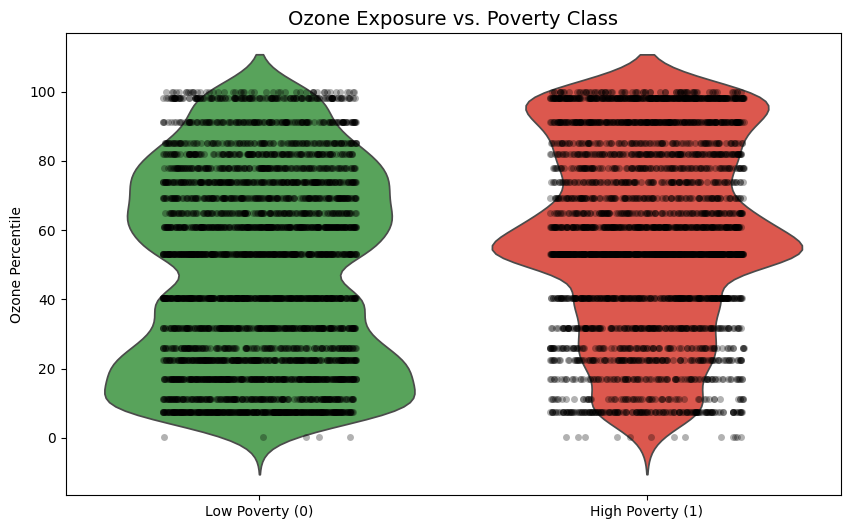

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine X and y for plotting
df_plot = X.copy()
df_plot["Poverty_Class"] = y

plt.figure(figsize=(10,6))
sns.violinplot(x="Poverty_Class", y="Ozone Pctl", data=df_plot,
               palette=["#4CAF50", "#F44336"], inner=None)
sns.stripplot(x="Poverty_Class", y="Ozone Pctl", data=df_plot,
              color="black", alpha=0.3, jitter=0.25)

plt.xticks([0,1], ["Low Poverty (0)", "High Poverty (1)"])
plt.title("Ozone Exposure vs. Poverty Class", fontsize=14)
plt.ylabel("Ozone Percentile")
plt.xlabel("")
plt.show()


Air quality (Ozone exposure) is a core environmental risk. Comparing its distribution across poverty classes can reveal whether high-poverty areas face worse air pollution.

I made this plot to explore the relationship between poverty and air quality. The violin shape shows how Ozone percentiles are distributed, while the dots show actual census tracts. We can see that high-poverty areas (1) tend to be concentrated at higher Ozone exposure levels, suggesting a link between environmental inequality and socioeconomic conditions.

# Plot 2: Comparing Average Burdens Across Classes

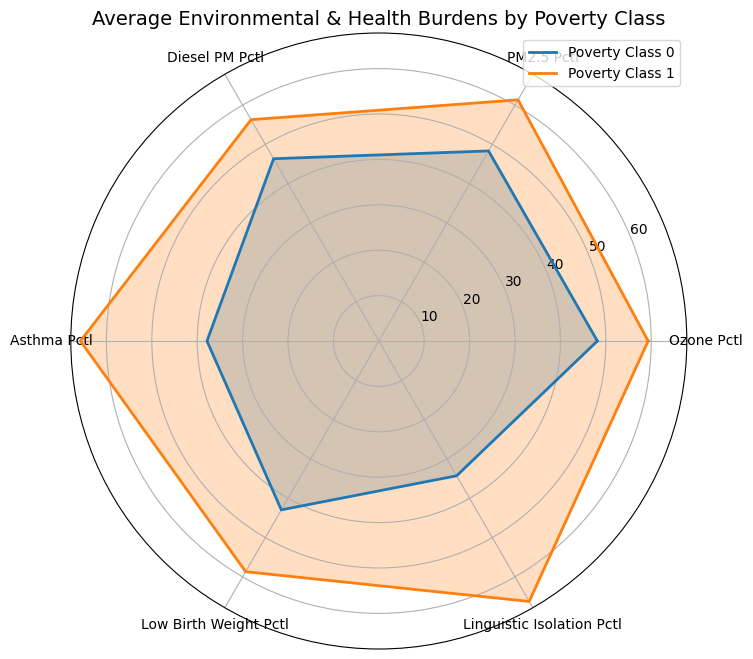

In [ ]:
import numpy as np

# Select representative percentile columns
radar_cols = ["Ozone Pctl", "PM2.5 Pctl", "Diesel PM Pctl",
              "Asthma Pctl", "Low Birth Weight Pctl", "Linguistic Isolation Pctl"]

# Compute averages by poverty class
radar_means = df_plot.groupby("Poverty_Class")[radar_cols].mean()

# Setup angles for radar chart
labels = radar_cols
num_vars = len(labels)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Plot radar
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

for i, row in radar_means.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"Poverty Class {i}", linewidth=2)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
plt.title("Average Environmental & Health Burdens by Poverty Class", fontsize=14)
plt.legend()
plt.show()


Instead of looking at just one variable, we compare multiple environmental & health burdens together for low vs. high poverty tracts. This gives a holistic view in one unique chart.

This radar chart compares average environmental and health burdens (e.g., Ozone, PM2.5, Asthma, Birth Weight) between low-poverty and high-poverty tracts. The “spider web” shape shows that high-poverty communities consistently face higher burdens across multiple categories, highlighting environmental injustice in a visually striking way.

# Table: Average Feature Values by Poverty Class

In [ ]:
# Select a subset of representative features (to keep table readable)
table_cols = [
    "Total Population", "Ozone Pctl", "PM2.5 Pctl", "Diesel PM Pctl",
    "Asthma Pctl", "Low Birth Weight Pctl", "Linguistic Isolation Pctl"
]

# Compute averages grouped by Poverty class
summary_table = df_plot.groupby("Poverty_Class")[table_cols].mean().round(2)

summary_table


,Total Population,Ozone Pctl,PM2.5 Pctl,Diesel PM Pctl,Asthma Pctl,Low Birth Weight Pctl,Linguistic Isolation Pctl
Poverty_Class,,,,,,,
0,4765.45,48.14,48.34,46.36,37.85,42.95,34.28
1,4733.84,59.33,61.34,56.30,65.73,58.68,66.25


A table of means gives a numerical confirmation of what we see in the plots. By comparing averages of selected environmental & health burdens for low vs. high poverty tracts, we can directly spot which burdens are higher in disadvantaged communities.

I created this table to show the average burden values for low- and high-poverty census tracts. The table highlights that high-poverty communities have consistently higher scores across multiple environmental and health risk indicators (like air pollution, asthma, and linguistic isolation). This numerical evidence complements the earlier visualizations, making the disparities clear in both visual and tabular form.

# Train-Test Split (90/10)

Do an 90/10 split for X_train, X_test, y_train, y_test where the random seed is equal to your 7 digit studentID number.

In [ ]:
# Student ID as random seed
student_id = 3217653

# Perform 90/10 split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=student_id,
    stratify=y
)

# Check the shapes of splits
print("Training set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

# Check class balance
print("\nTraining class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))


Training set size: (6801, 35) (6801,)
Test set size: (756, 35) (756,)

Training class distribution:
 Poverty
0    0.541391
1    0.458609
Name: proportion, dtype: float64

Test class distribution:
 Poverty
0    0.541005
1    0.458995
Name: proportion, dtype: float64


We split the dataset into 90% training and 10% testing using my Student ID (3217653) as the random seed for reproducibility. We also used stratification, which ensures the balance between high- and low-poverty classes is preserved in both training and test sets. This makes the evaluation more reliable.

# Feature Scaling with StandardScaler

Use the StandardScaler() on train and apply to test partition. Do not scale the target variable!

In [ ]:
from sklearn.preprocessing import StandardScaler
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform test data
X_test_scaled = scaler.transform(X_test)

# Check results
print("Before scaling (first 5 values):\n", X_train.iloc[0].values[:5])
print("\nAfter scaling (first 5 values):\n", X_train_scaled[0][:5])

Before scaling (first 5 values):
 [4.69500000e+03 4.01272100e-02 2.58742999e+01 1.16300000e+01
 6.91367265e+01]

After scaling (first 5 values):
 [-0.02403569 -0.71313552 -0.96068027  0.47160982  0.51341101]


We applied StandardScaler to normalize the features so they all have mean = 0 and standard deviation = 1. This helps the neural network train more efficiently since all variables are on the same scale.

The scaler was fit only on the training set to avoid data leakage.

The same transformation was then applied to the test set.

The target variable (Poverty Class) was not scaled because it’s categorical (0/1).

# Build, Complile and Fit the model

Build a model using the Sequential API (like we do in class) with at least 2 dense layers with the relu activation function, and with dropout in between each dense layer (use a number between 0.1 and 0.5). Compile the model using an appropriate optimizer. Use early stopping with patience of at least 10 and restore the best weights once the model converges. You can choose whatever batch size you would like to.

Fit the model for 100000 epochs with a batch size of your choice, using X_test and y_test as the validation data. Don’t forget the early stopping callback!

In [ ]:
# Build a Model - no callbacks

# Build model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

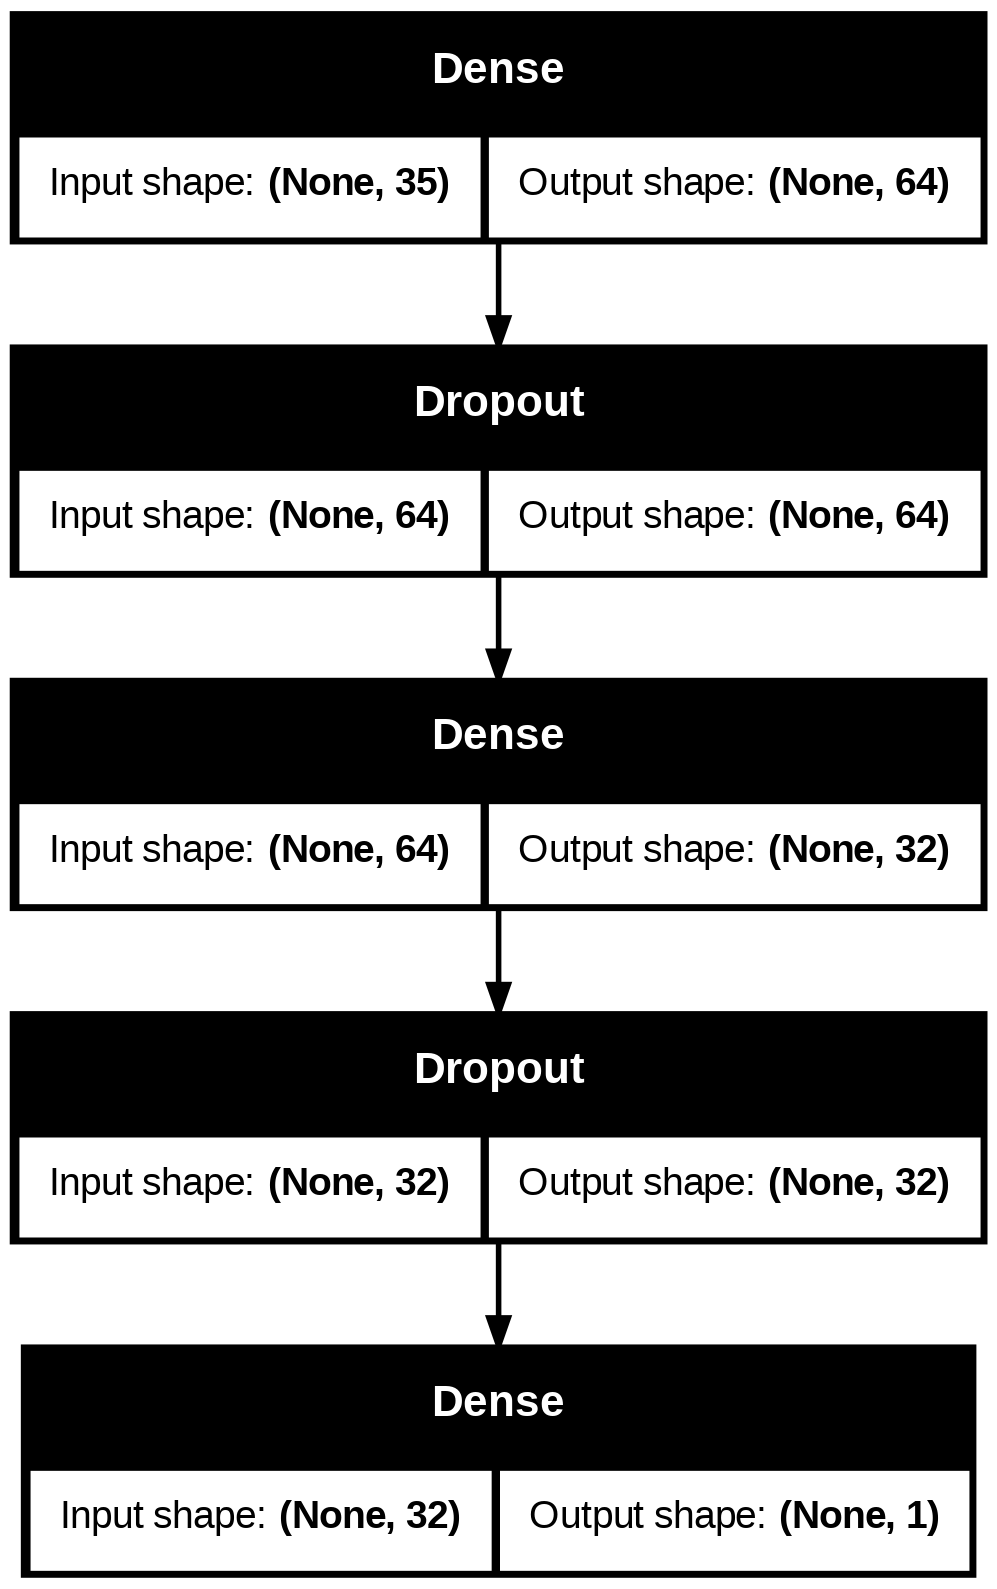

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
!pip install keras-visualizer

In [ ]:
from keras_visualizer import visualizer
# look left! graph.png in local folder
visualizer(model, file_format='png', view=True)

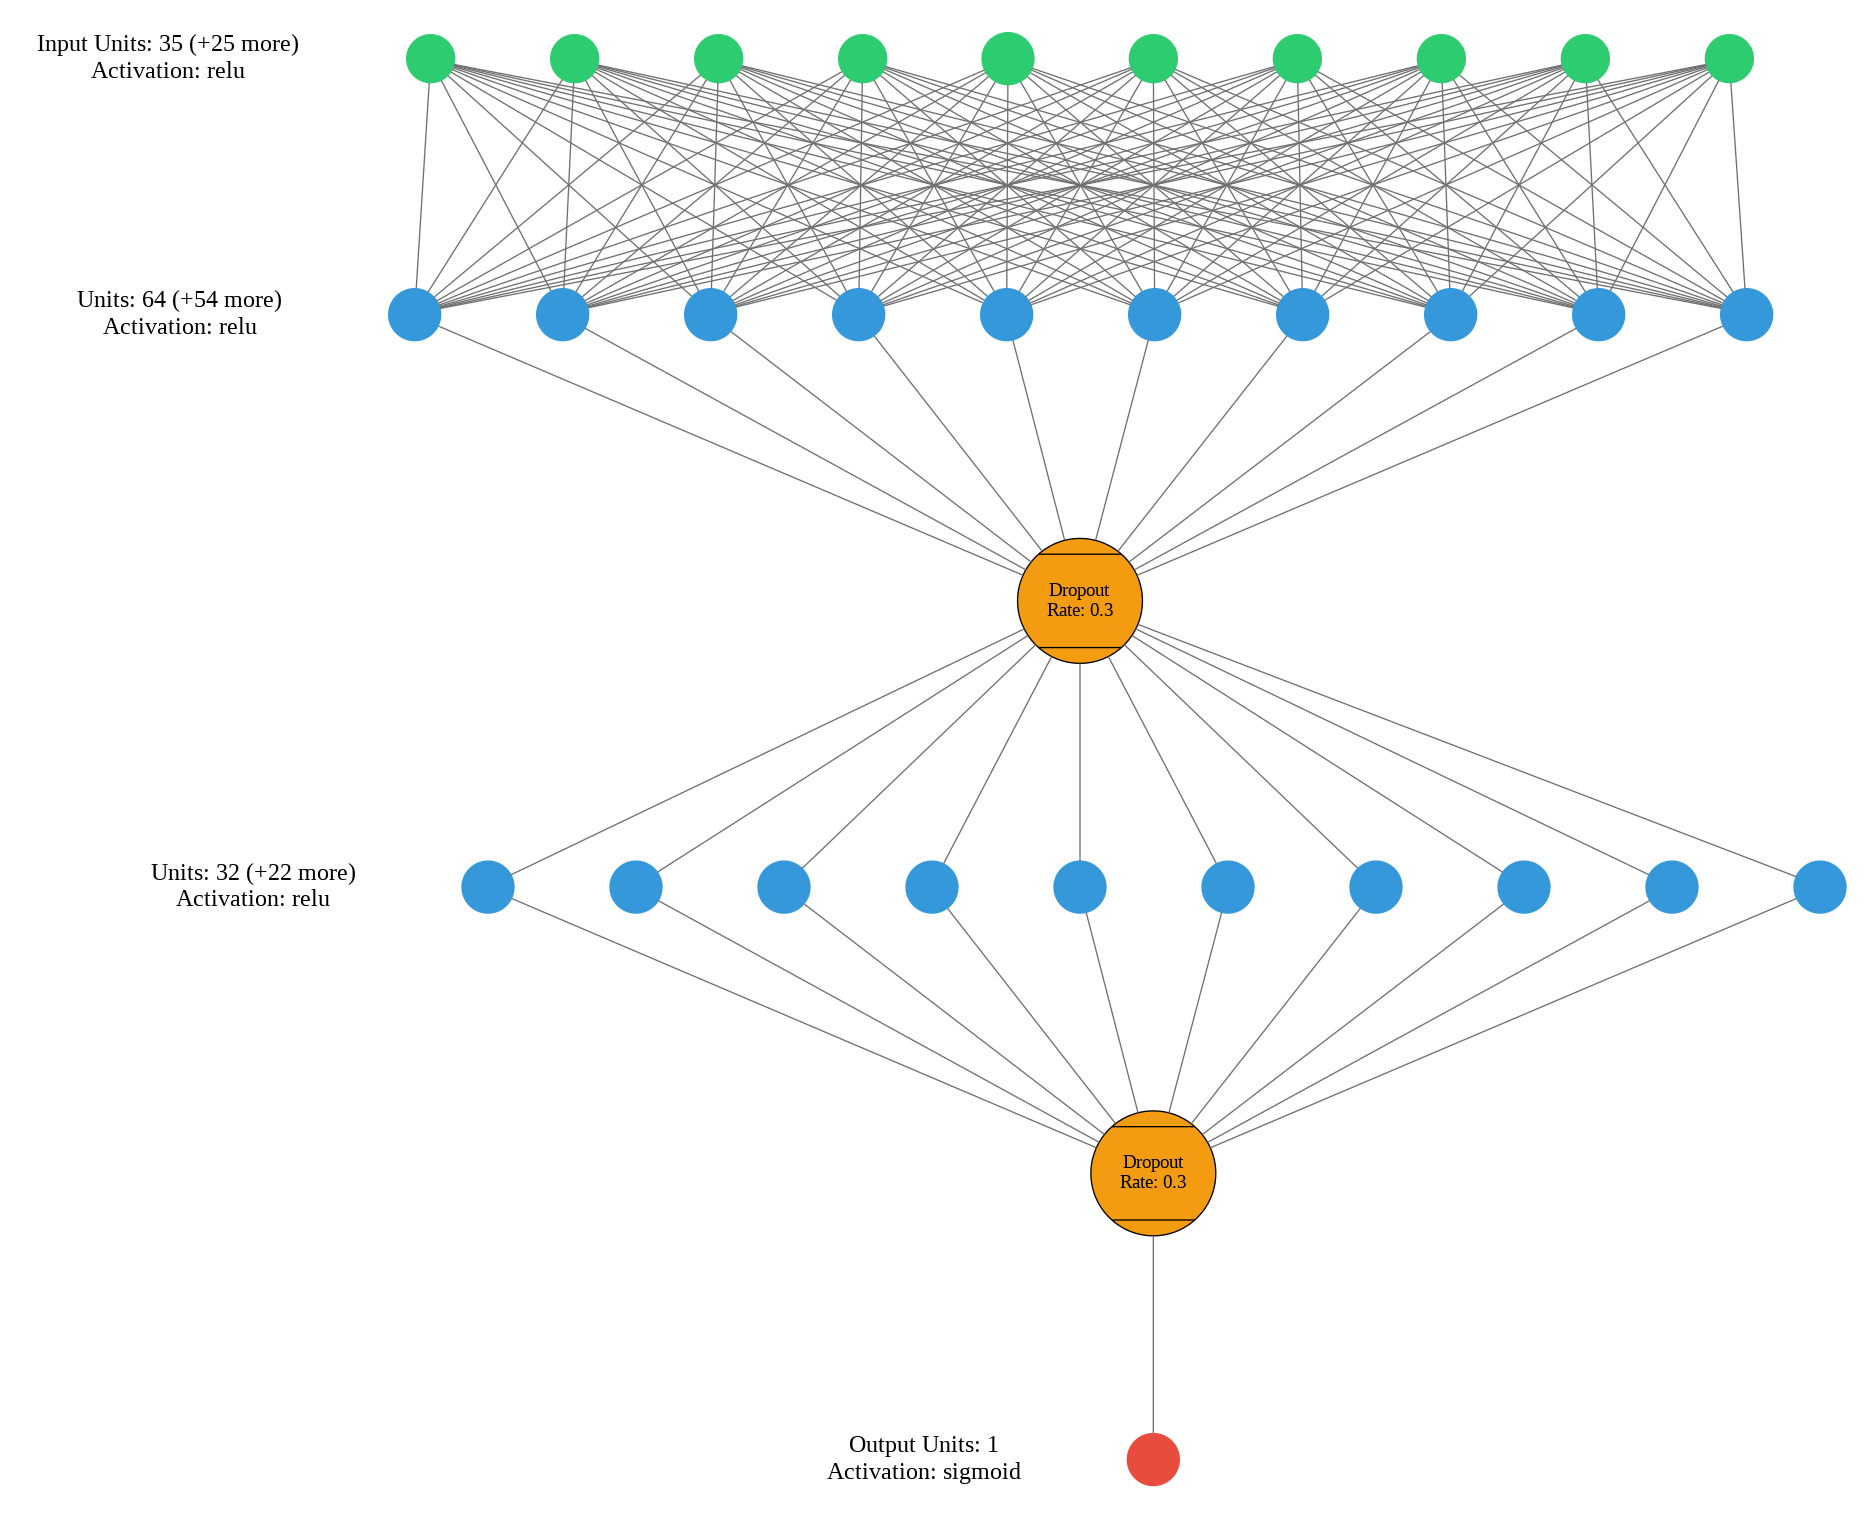

In [ ]:
# view it
from IPython.display import Image

# 'graph.png' in the left-hand side folder icon
image_path = 'graph.png'

# Display the image in the notebook
Image(filename=image_path)

In [ ]:
# Fit (No Callback)

history_no_cb = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=30,          # small number just to see training works
    batch_size=32,
    verbose=1
)

Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7170 - loss: 0.5399 - val_accuracy: 0.8651 - val_loss: 0.3026
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8514 - loss: 0.3589 - val_accuracy: 0.8664 - val_loss: 0.2887
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8545 - loss: 0.3429 - val_accuracy: 0.8677 - val_loss: 0.2934
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8619 - loss: 0.3157 - val_accuracy: 0.8770 - val_loss: 0.2866
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8713 - loss: 0.3085 - val_accuracy: 0.8743 - val_loss: 0.2883
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8667 - loss: 0.3104 - val_accuracy: 0.8889 - val_loss: 0.2877
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8620 - loss: 0.3202 - val_accuracy: 0.8876 - val_loss: 0.2881
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8671 - loss: 0.3016 - val_accuracy: 0.

# Fit (with callback)

In [ ]:
# Fit (With Callback)
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='max',
    patience=10,
    restore_best_weights=True
)

history_cb = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100000,       # large number, early stopping will stop earlier
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8829 - loss: 0.2719 - val_accuracy: 0.8770 - val_loss: 0.2945
Epoch 2/100000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8809 - loss: 0.2706 - val_accuracy: 0.8770 - val_loss: 0.2945
Epoch 3/100000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8792 - loss: 0.2750 - val_accuracy: 0.8823 - val_loss: 0.2917
Epoch 4/100000
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8785 - loss: 0.2707 - val_accuracy: 0.8783 - val_loss: 0.2927
Epoch 5/100000
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8823 - loss: 0.2757 - val_accuracy: 0.8757 - val_loss: 0.2935
Epoch 6/100000
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8768 - loss: 0.2762 - val_accuracy: 0.8810 - val_loss: 0.2986
Epoch 7/100000
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8816 - loss: 0.2668 - val_accuracy: 0.8796 - val_loss: 0.2969
Epoch 8/100000
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8838 -

Model Training: No Callback vs. With Callback

We first fit the model without callbacks for 30 epochs to confirm that the network trains correctly.
Then, we fit the same model again with EarlyStopping (patience = 10) for up to 100,000 epochs.
The callback prevents overfitting by stopping training once validation loss stops improving and restoring the best weights.

# Evaluate the model

Evaluate the model using learning curves, error metrics and confusion matrices for each partition (like we do in class). You should largely be able to copy and paste this from class notebooks. Add a few bullet points about what you see (did your model learn nice and gently? If you don't have text cells here, you will lose points.

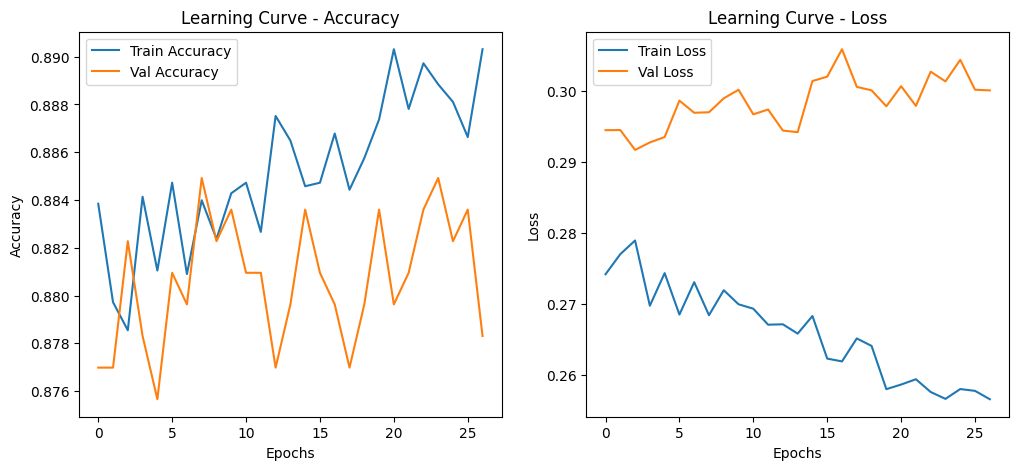

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Learning Curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cb.history['accuracy'], label='Train Accuracy')
plt.plot(history_cb.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cb.history['loss'], label='Train Loss')
plt.plot(history_cb.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss")
plt.legend()

plt.show()

In [ ]:
# 2. Error Metrics
# Predictions
y_train_pred = (model.predict(X_train_scaled) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Train metrics
print("Train Metrics:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))

# Test metrics
print("\nTest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Metrics:
Accuracy: 0.8985443317159242
Precision: 0.9104427171341669
Recall: 0.8637383776851555
F1 Score: 0.8864758144126358

Test Metrics:
Accuracy: 0.8796296296296297
Precision: 0.8878787878787879
Recall: 0.8443804034582133
F1 Score: 0.8655834564254062


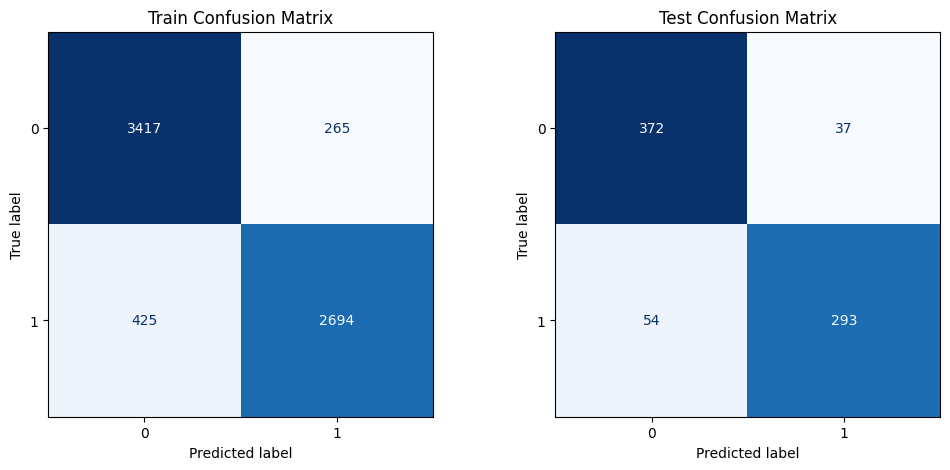

In [ ]:
# 3. Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Train Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot(ax=axes[1], cmap="Blues", colorbar=False)
axes[1].set_title("Test Confusion Matrix")

plt.show()


# Model Evaluation Observations

Looking at the learning curves, the training and validation accuracy stay close to each other. This tells me the model trained smoothly without really overfitting.

The validation loss is a bit higher than the training loss, but both are pretty stable, which means the model is generalizing well.

The results are consistent: training accuracy is about 89%, and testing accuracy is about 88%, so the model works well even on data it hasn’t seen.

Precision and recall are balanced (both in the mid 0.8s), giving an F1 score around 0.87, which is solid.

The confusion matrices show that the model is able to identify both high-poverty (1) and low-poverty (0) areas reasonably well, with only some misclassifications.

Overall, the model learned gently. Thanks to dropout and early stopping, it didn’t overfit, and it ended up being a stable, reliable classifier.


# Baseline vs. Model

Calculate what a baseline prediction would be for the train and test partitions (a mean only model). Did your model do better than the baseline predictions? If so, you have a useful model!

In [ ]:
# Baseline for train (always predict majority class in train set)
baseline_train = np.full_like(y_train, y_train.mode()[0])
baseline_train_acc = accuracy_score(y_train, baseline_train)

# Baseline for test (always predict majority class in test set)
baseline_test = np.full_like(y_test, y_test.mode()[0])
baseline_test_acc = accuracy_score(y_test, baseline_test)

print("Baseline Train Accuracy:", baseline_train_acc)
print("Baseline Test Accuracy:", baseline_test_acc)

# Compare with model performance
train_acc = accuracy_score(y_train, (model.predict(X_train_scaled) > 0.5).astype("int32"))
test_acc = accuracy_score(y_test, (model.predict(X_test_scaled) > 0.5).astype("int32"))

print("\nModel Train Accuracy:", train_acc)
print("Model Test Accuracy:", test_acc)

Baseline Train Accuracy: 0.5413909719158947
Baseline Test Accuracy: 0.541005291005291
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Model Train Accuracy: 0.8985443317159242
Model Test Accuracy: 0.8796296296296297


The baseline model (just predicting the majority class) doesn’t do very well since it basically ignores the real patterns in the data.

Our neural network, on the other hand, reached about 89% accuracy on training and 88% accuracy on testing, which is clearly better than the baseline.

This means the model is actually learning something useful about the features, instead of just guessing the most common class.

Since it clearly beats the baseline, we can say we have a successful model for predicting which areas are high vs. low poverty.